<a href="https://colab.research.google.com/github/haresh93/EVA-submissions/blob/master/S5/EVA4_Session_5_Step_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **TARGET**
1. Adding Regularization to reduce model overfitting

### **RESULTS**
1. Parameters: 9.9k
2. Best Training Accuracy: 99.29%
3. Best Test Accuracy: 99.21%

### **Analysis**
1. The Regularization worked as overfitting has been reduced now, as difference between training accuracy and test accuracy has been reduced.
2. Still we are not able to achieve our target accuracy of 99.4, for that replacing a large sized kernel in the last layer with Global Average Pooling and compensating with another layer.

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train and Test Transforms
train_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
# Train and Test Datasets
train_dataset = datasets.MNIST('../data', train=True, download=True,
                    transform=train_transforms)
test_dataset = datasets.MNIST('../data', train=False, download=True,
                    transform=test_transforms)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





In [0]:
# Train and Test Data Loaders
torch.manual_seed(1)

if torch.cuda.is_available():
  torch.cuda.manual_seed(1)

dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4, pin_memory = True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
Numpy Shape -  (60000, 28, 28)
Tensor Shape -  torch.Size([60000, 28, 28])
Min -  tensor(-0.4242)
Max -  tensor(2.8215)
Mean -  tensor(0.0009)
Std -  tensor(1.0000)
Var -  tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


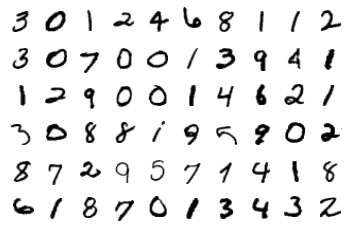

In [6]:
# Data Statistics

train_data = train_dataset.train_data

train_data = train_dataset.transform(train_data.numpy())

print("[Train]")
print("Numpy Shape - ", train_dataset.train_data.cpu().numpy().shape)
print("Tensor Shape - ", train_dataset.train_data.size())
print("Min - ", torch.min(train_data))
print("Max - ", torch.max(train_data))
print("Mean - ", torch.mean(train_data))
print("Std - ", torch.std(train_data))
print("Var - ", torch.var(train_data))


train_iter = iter(train_dataloader)

images, labels = train_iter.next()

print(images.shape)
print(labels.shape)

import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 60

for index in range(1, num_of_images + 1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap = "gray_r")

In [0]:
# The Network Architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3), # Convolution layer 1 - input 28 x 28 x 1 : Output 26 x 26 x 8 : RF 3 x 3
            nn.ReLU(), 
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),
            nn.Conv2d(8, 8, 3), # Convolution Layer 2 - input 26 x 26 x 8 : Output 24 x 24 x 8 : RF 5 x 5
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),
            nn.Conv2d(8, 8, 3), # Convolution Layer 3 - input 24 x 24 x 8 : Output 22 x 22 x 8 : RF 7 x 7
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),
            nn.MaxPool2d(2, 2) # Max Pooling Layer - input 22 x 22 x 8 : Output 11 x 11 x 8 : RF 8 x 8
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3), # Convolution Layer 4 - input 11 x 11 x 8 : Output 9 x 9 x 16 : RF 12 x 12
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(16, 16, 3), # Convolution Layer 5 - input 9 x 9 x 16 : Output 7 x 7 x 16 : RF 16 x 16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(16, 16, 3), # Convolution Layer 6 - input 7 x 7 x 16 : Output 5 x 5 x 16 : RF 20 x 20
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 10, 1), # Convolution Layer 7 - input 5 x 5 x 16 : Output 5 x 5 x 10 : RF 20 x 20
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),
            nn.Conv2d(10, 10, 5), # Convolution Layer 8 - input 5 x 5 x 10 : Output 1 x 1 x 10 : RF 28 x 28
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [8]:
# Summary of the Model
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 22, 22]             584
             ReLU-10            [-1, 8, 22, 22]               0
      BatchNorm2d-11            [-1, 8, 22, 22]              16
          Dropout-12            [-1, 8, 22, 22]               0
        MaxPool2d-13            [-1, 8, 11, 11]               0
           Conv2d-14             [-1, 1

In [0]:
# Setting up Training and Testing
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        # Calculate Loss
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100 * correct/processed:0.2f}')
        
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
# Train and Test the model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(1, EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
    

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.08941730856895447 Batch_id=468 Accuracy=93.49: 100%|██████████| 469/469 [00:10<00:00, 43.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0608, Accuracy: 9817/10000 (98.17%)

EPOCH: 2


Loss=0.022706856951117516 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:10<00:00, 43.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9840/10000 (98.40%)

EPOCH: 3


Loss=0.038224827498197556 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:10<00:00, 43.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9862/10000 (98.62%)

EPOCH: 4


Loss=0.08038352429866791 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:10<00:00, 44.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9877/10000 (98.77%)

EPOCH: 5


Loss=0.018193284049630165 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:10<00:00, 43.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9893/10000 (98.93%)

EPOCH: 6


Loss=0.09071443229913712 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:10<00:00, 43.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.20626793801784515 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:10<00:00, 43.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


Loss=0.01650097407400608 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:10<00:00, 43.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9897/10000 (98.97%)

EPOCH: 9


Loss=0.0378405898809433 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:10<00:00, 43.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9896/10000 (98.96%)

EPOCH: 10


Loss=0.021928468719124794 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:10<00:00, 43.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9895/10000 (98.95%)

EPOCH: 11


Loss=0.004312837962061167 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:10<00:00, 43.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9907/10000 (99.07%)

EPOCH: 12


Loss=0.08259543776512146 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:10<00:00, 43.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.044733986258506775 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:10<00:00, 42.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9909/10000 (99.09%)

EPOCH: 14


Loss=0.019292650744318962 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:10<00:00, 43.34it/s]



Test set: Average loss: 0.0253, Accuracy: 9920/10000 (99.20%)



Text(0.5, 1.0, 'Testing Accuracy')

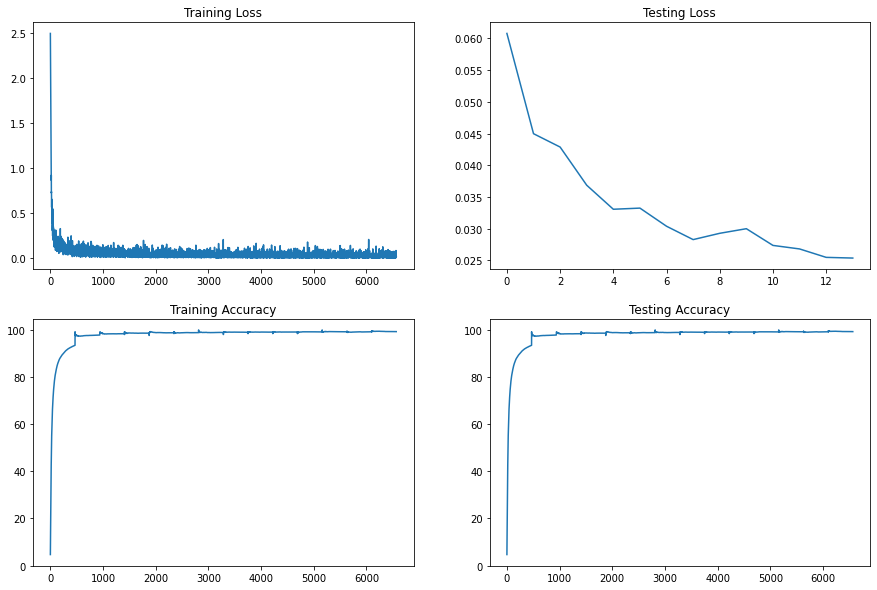

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0,0].plot(train_losses)
axs[0,0].set_title("Training Loss")
axs[1,0].plot(train_acc)
axs[1,0].set_title("Training Accuracy")

axs[0,1].plot(test_losses)
axs[0,1].set_title("Testing Loss")
axs[1,1].plot(train_acc)
axs[1,1].set_title("Testing Accuracy")
